In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
from scipy.interpolate import interp1d
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math
from tf_agents.replay_buffers import tf_uniform_replay_buffer

2022-10-06 20:47:29.414397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 20:47:29.507352: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-06 20:47:29.531864: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 20:47:30.005638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# tf.config.run_functions_eagerly(True)
tf.config.run_functions_eagerly(False)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
y_train.shape

(50000, 1)

In [5]:
def preprocess_images(images):
    return 2.*(images.astype("float32") / 255.) - 1.

def preprocess_labels(labels):
    return labels.astype("int32")

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

y_train = preprocess_labels(y_train)
y_test = preprocess_labels(y_test)

In [6]:
train_size = len(X_train)
batch_size = 32
test_size = len(X_test)

In [7]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)


2022-10-06 20:47:31.875368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 20:47:32.509222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22276 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
                 .shuffle(train_size).batch(batch_size, drop_remainder=True))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                .shuffle(test_size).batch(batch_size, drop_remainder=True))

train_cond_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .shuffle(train_size).batch(batch_size, drop_remainder=True))
test_cond_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                .shuffle(test_size).batch(batch_size, drop_remainder=True))

In [9]:
def display_samples(samples):
    n = len(samples)
    c = 10
    r = n // c
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(samples.shape[0]):
        ri = i // c
        ci = i % c
        axs[ri, ci].imshow(samples[i])

In [10]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "dcgan")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [11]:
class ModelSnapshotter(keras.callbacks.Callback):
    def __init__(self, frequency):
        super().__init__()
        self._frequency = frequency
        self._weights = []
    
    def on_epoch_end(self, epoch, logs):
        if epoch % self._frequency == 0:
            disc_weights = self.model.discriminator.get_weights()
            gen_weights = self.model.generator.get_weights()
            self._weights.append((disc_weights, gen_weights))

In [12]:
class DCGAN(tf.keras.Model):
    def __init__(self, latent_dim, image_shape, class_dim=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.class_dim = class_dim
        
        gen_latent_input = keras.layers.Input(shape=[latent_dim])
        gen_latent_dense = keras.layers.Dense(8*8*128, activation="relu")(gen_latent_input)
        gen_latent_reshaped = keras.layers.Reshape((8, 8, 128))(gen_latent_dense)
        if class_dim:
            gen_class_input = keras.layers.Input(shape=[1], dtype=tf.int32)
            gen_class_embedding = keras.layers.Embedding(input_dim=class_dim, output_dim=50)(gen_class_input)
            gen_class_dense = keras.layers.Dense(8*8)(gen_class_embedding)
            gen_class_reshaped = keras.layers.Reshape((8, 8, 1))(gen_class_dense)
            gen_concat = keras.layers.Concatenate()([gen_latent_reshaped, gen_class_reshaped])
        else:
            gen_concat = gen_latent_reshaped
            
        gen_conv = keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu")(gen_concat)
        gen_conv = keras.layers.BatchNormalization()(gen_conv)
        gen_conv = keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu")(gen_conv)
        gen_conv = keras.layers.BatchNormalization()(gen_conv)
        gen_conv = keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh")(gen_conv)
        
        if class_dim:
            self.generator = keras.models.Model(inputs=[gen_latent_input, gen_class_input], outputs=gen_conv)
        else:
            self.generator = keras.models.Model(inputs=gen_latent_input, outputs=gen_conv)
        
        
        disc_img_input = keras.layers.Input(shape=image_shape)
        
        if class_dim:
            disc_class_input = keras.layers.Input(shape=[1], dtype=tf.int32)
            disc_class_embedding = keras.layers.Embedding(input_dim=class_dim, output_dim=50)(disc_class_input)
            disc_class_dense = keras.layers.Dense(image_shape[0]*image_shape[1]*image_shape[2])(disc_class_embedding)
            disc_class_reshaped = keras.layers.Reshape((image_shape[0], image_shape[1], image_shape[2]))(disc_class_dense)
            disc_conv = keras.layers.Concatenate()([disc_img_input, disc_class_reshaped])
        else:
            disc_conv = disc_img_input
        
        disc_conv = keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2))(disc_conv)
        disc_conv = keras.layers.BatchNormalization()(disc_conv)
        disc_conv = keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2))(disc_conv)
        disc_conv = keras.layers.BatchNormalization()(disc_conv)
        disc_flat = keras.layers.Flatten()(disc_conv)
        disc_dropout = keras.layers.Dropout(0.4)(disc_flat)
        disc_dense = keras.layers.Dense(1)(disc_dropout)
        
        if self.class_dim:
            self.discriminator = keras.models.Model(inputs=[disc_img_input, disc_class_input], outputs=disc_dense)
        else:
            self.discriminator = keras.models.Model(inputs=disc_img_input, outputs=disc_dense)
        
        self.bce = keras.losses.BinaryCrossentropy(from_logits=True)
    
    @tf.function
    def sample(self, n_samples=10, labels=None):
        if self.class_dim:
            if labels:
                n_samples = len(labels)
                labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)
            else:
                labels_tensor = tf.random.uniform(shape=[n_samples, 1], minval=0, maxval=self.class_dim, dtype=np.int32)
        inputs = tf.random.normal(shape=[n_samples, self.latent_dim])
        if self.class_dim:
            inputs = (inputs, labels_tensor)
        
        return self.generator(inputs)
    
    def compute_loss(self, x, y, y_pred, sample_weights):
        return self.bce(y, y_pred)
    
    def train_step(self, X_batch):
        if self.class_dim:
            X_batch, y_batch = X_batch
        
        X_batch_shape = tf.shape(X_batch)
        batch_size = X_batch_shape[0]
        
        noise_1 = tf.random.normal(shape=[batch_size, self.latent_dim])
        if self.class_dim:
            labels_fake_1 = tf.random.uniform(shape=[batch_size, 1], minval=0, maxval=self.class_dim, dtype=np.int32)
            labels_fake_and_real = tf.concat([labels_fake_1, y_batch], axis=0)
            noise_1 = (noise_1, labels_fake_1)
            
        generated_images = self.generator(noise_1)
        X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
        
        if self.class_dim:
            X_fake_and_real = (X_fake_and_real, labels_fake_and_real)
        
        y1 = tf.concat([tf.zeros(batch_size), tf.ones(batch_size)], axis=0)
        
        with tf.GradientTape() as tape:
            y1_pred = self.discriminator(X_fake_and_real)
            disc_loss = self.compute_loss(None, y1, y1_pred, None)
        
        disc_gradients = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_weights))
        
        noise_2 = tf.random.normal(shape=[batch_size, self.latent_dim])
        if self.class_dim:
            labels_fake_2 = tf.random.uniform(shape=[batch_size, 1], minval=0, maxval=self.class_dim, dtype=np.int32)
            noise_2 = (noise_2, labels_fake_2)
        
        y2 = tf.ones(batch_size)
        
        with tf.GradientTape() as tape:
            generated_images_2 = self.generator(noise_2)
            if self.class_dim:
                generated_images_2 = (generated_images_2, labels_fake_2)
            y2_pred = self.discriminator(generated_images_2)
            gen_loss = self.compute_loss(None, y2, y2_pred, None)
        
        gen_gradients = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_weights))
        
        return {"disc_loss": disc_loss, "gen_loss": gen_loss}

In [13]:
dcgan_100_history = ModelSnapshotter(1)
dcgan_100 = DCGAN(100, [32, 32, 3])
dcgan_100.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
dcgan_100.fit(
    train_dataset, 
    epochs=100,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_100_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/100


2022-10-06 20:47:37.997848: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-06 20:47:38.459768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-06 20:47:39.226325: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 20:47:39.227652: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 20:47:39.227692: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-06 20:47:39.228763: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 20:47:39.228873: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

1562/1562 [==============================] - 23s 13ms/step - disc_loss: 0.5294 - gen_loss: 1.6264
Epoch 2/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.5732 - gen_loss: 1.2582
Epoch 3/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6298 - gen_loss: 1.0696
Epoch 4/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6454 - gen_loss: 0.9825
Epoch 5/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6763 - gen_loss: 0.8486
Epoch 6/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6868 - gen_loss: 0.7918
Epoch 7/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6891 - gen_loss: 0.7743
Epoch 8/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6907 - gen_loss: 0.7650
Epoch 9/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6902 - gen_loss: 0.7551
Epoch 10/100
1562/1562

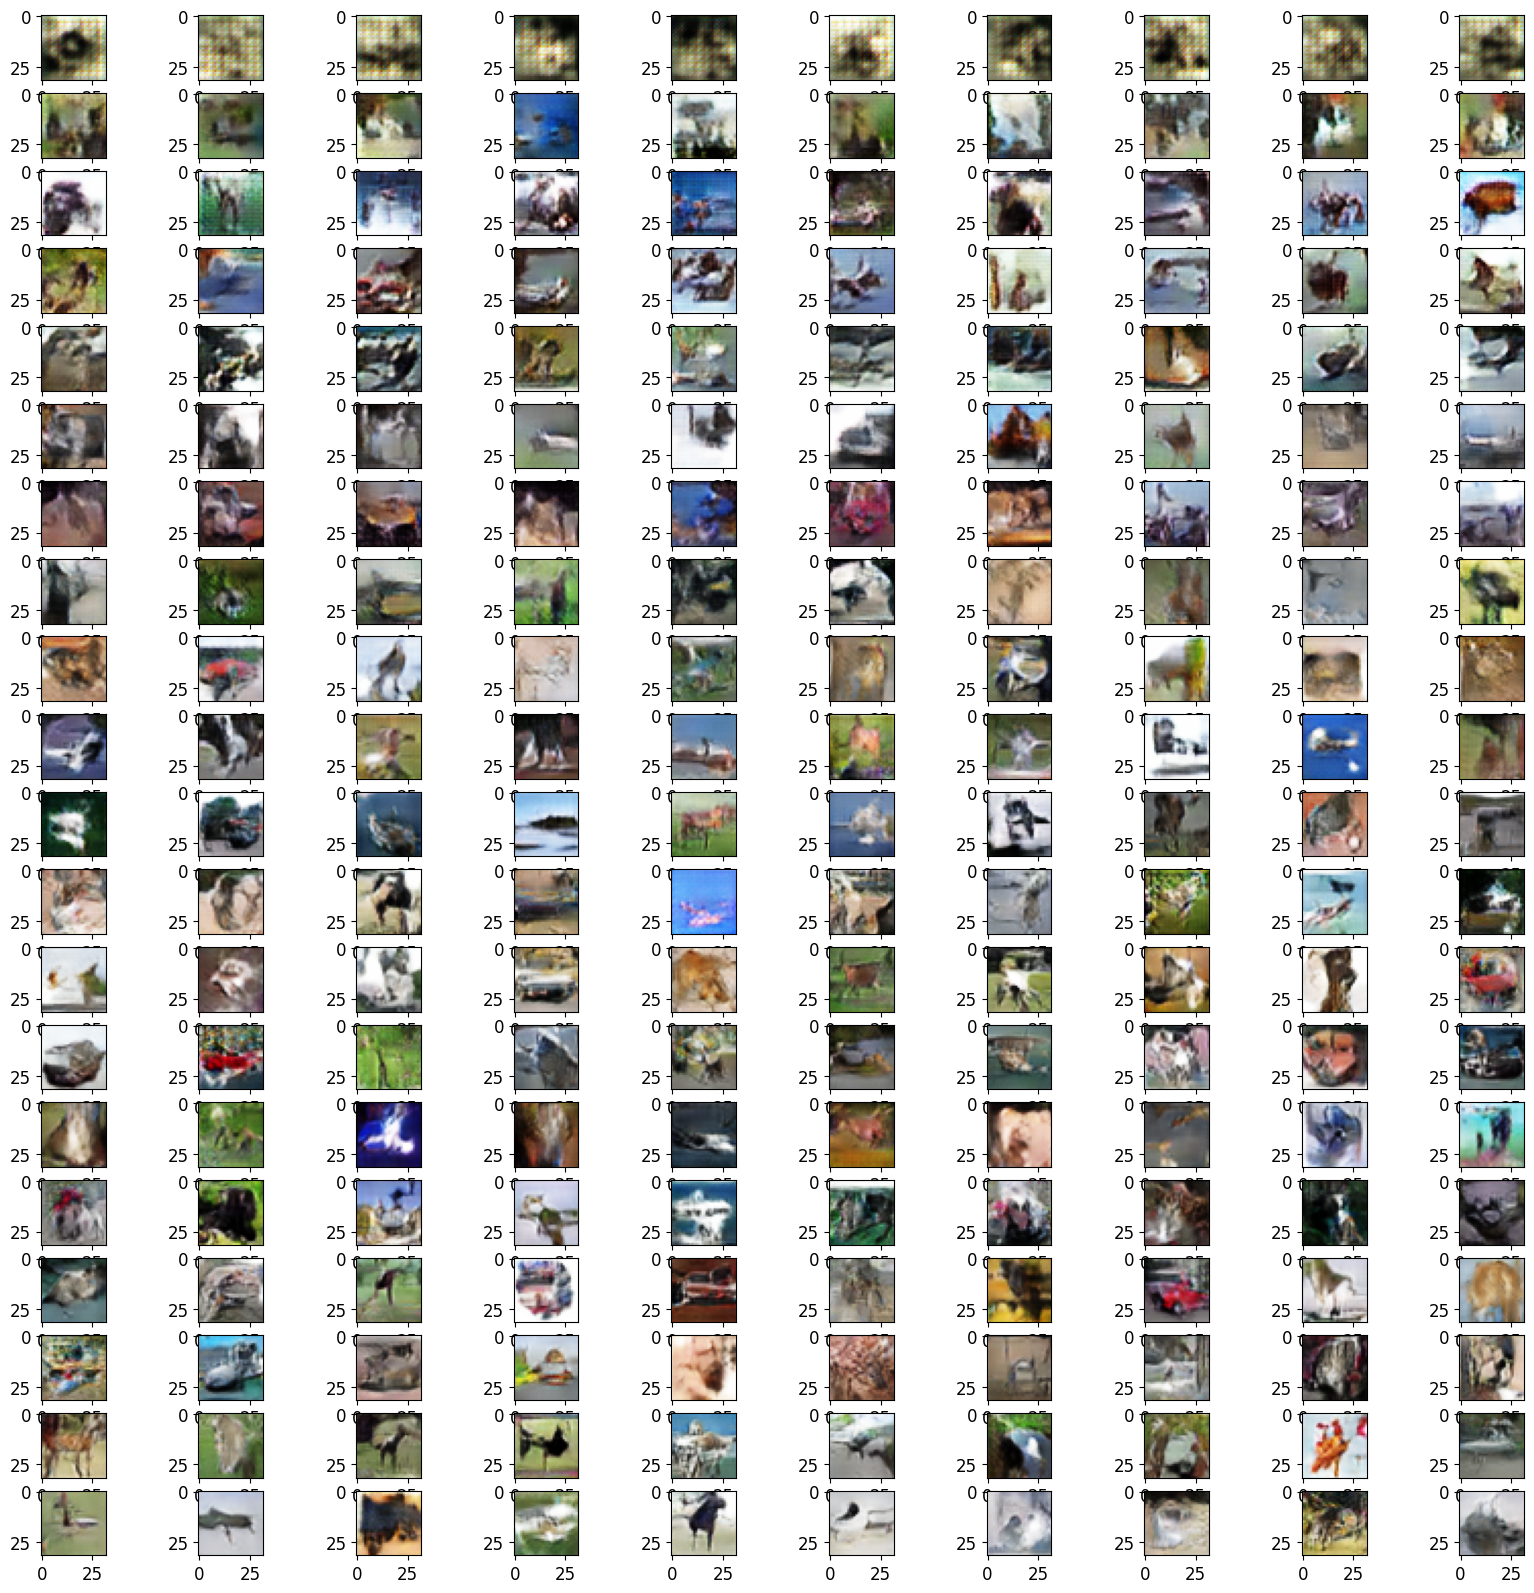

In [21]:
sample_list = []

for disc_weights, gen_weights in dcgan_100_history._weights[::5]:
    dcgan_100.discriminator.set_weights(disc_weights)
    dcgan_100.generator.set_weights(gen_weights)
    sample_list.append((dcgan_100.sample(n_samples=10) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)

In [15]:
dcgan_200_history = ModelSnapshotter(1)
dcgan_200 = DCGAN(200, [32, 32, 3])
dcgan_200.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
dcgan_200.fit(
    train_dataset, 
    epochs=100,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_200_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/100
1562/1562 [==============================] - 21s 13ms/step - disc_loss: 0.5088 - gen_loss: 1.7319
Epoch 2/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.5348 - gen_loss: 1.4588
Epoch 3/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.5868 - gen_loss: 1.2035
Epoch 4/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6274 - gen_loss: 1.0164
Epoch 5/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6606 - gen_loss: 0.9147
Epoch 6/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6721 - gen_loss: 0.8663
Epoch 7/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6798 - gen_loss: 0.8284
Epoch 8/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6802 - gen_loss: 0.8073
Epoch 9/100
1562/1562 [==============================] - 20s 13ms/step - disc_loss: 0.6828 - gen_loss: 0.7912
Epoch 10/1

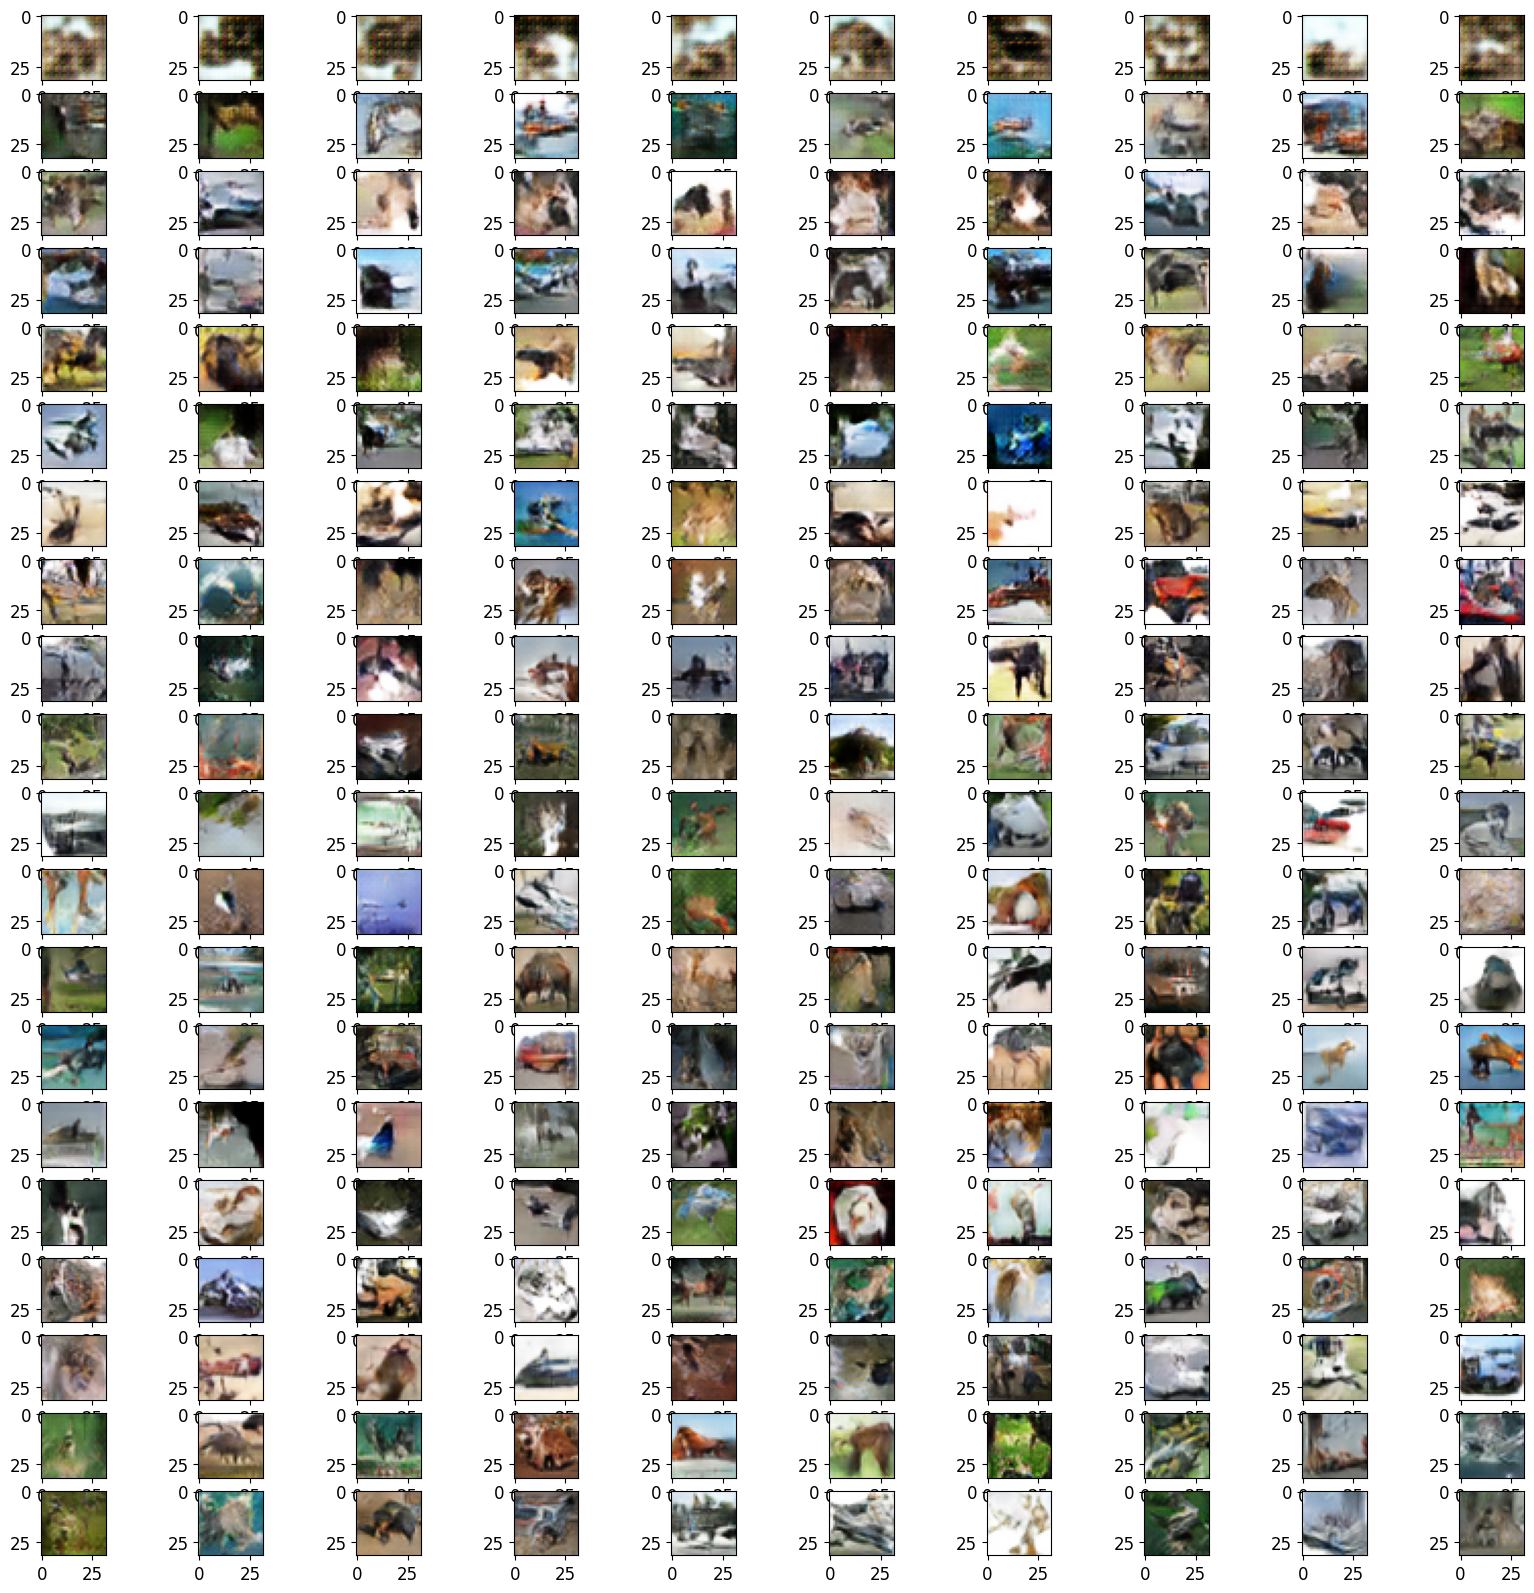

In [20]:
sample_list = []

for disc_weights, gen_weights in dcgan_200_history._weights[::5]:
    dcgan_200.discriminator.set_weights(disc_weights)
    dcgan_200.generator.set_weights(gen_weights)
    sample_list.append((dcgan_200.sample(n_samples=10) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)

In [17]:
dcgan_200_cond_history = ModelSnapshotter(1)
dcgan_200_cond = DCGAN(200, [32, 32, 3], class_dim=10)
dcgan_200_cond.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
dcgan_200_cond.fit(
    train_cond_dataset, 
    epochs=100,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_200_cond_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]
)

Epoch 1/100
1562/1562 [==============================] - 26s 15ms/step - disc_loss: 0.5304 - gen_loss: 1.6140
Epoch 2/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6106 - gen_loss: 1.0716
Epoch 3/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6248 - gen_loss: 1.0041
Epoch 4/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6516 - gen_loss: 0.9348
Epoch 5/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6575 - gen_loss: 0.8897
Epoch 6/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6629 - gen_loss: 0.8732
Epoch 7/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6618 - gen_loss: 0.8579
Epoch 8/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6614 - gen_loss: 0.8491
Epoch 9/100
1562/1562 [==============================] - 23s 15ms/step - disc_loss: 0.6629 - gen_loss: 0.8441
Epoch 10/1

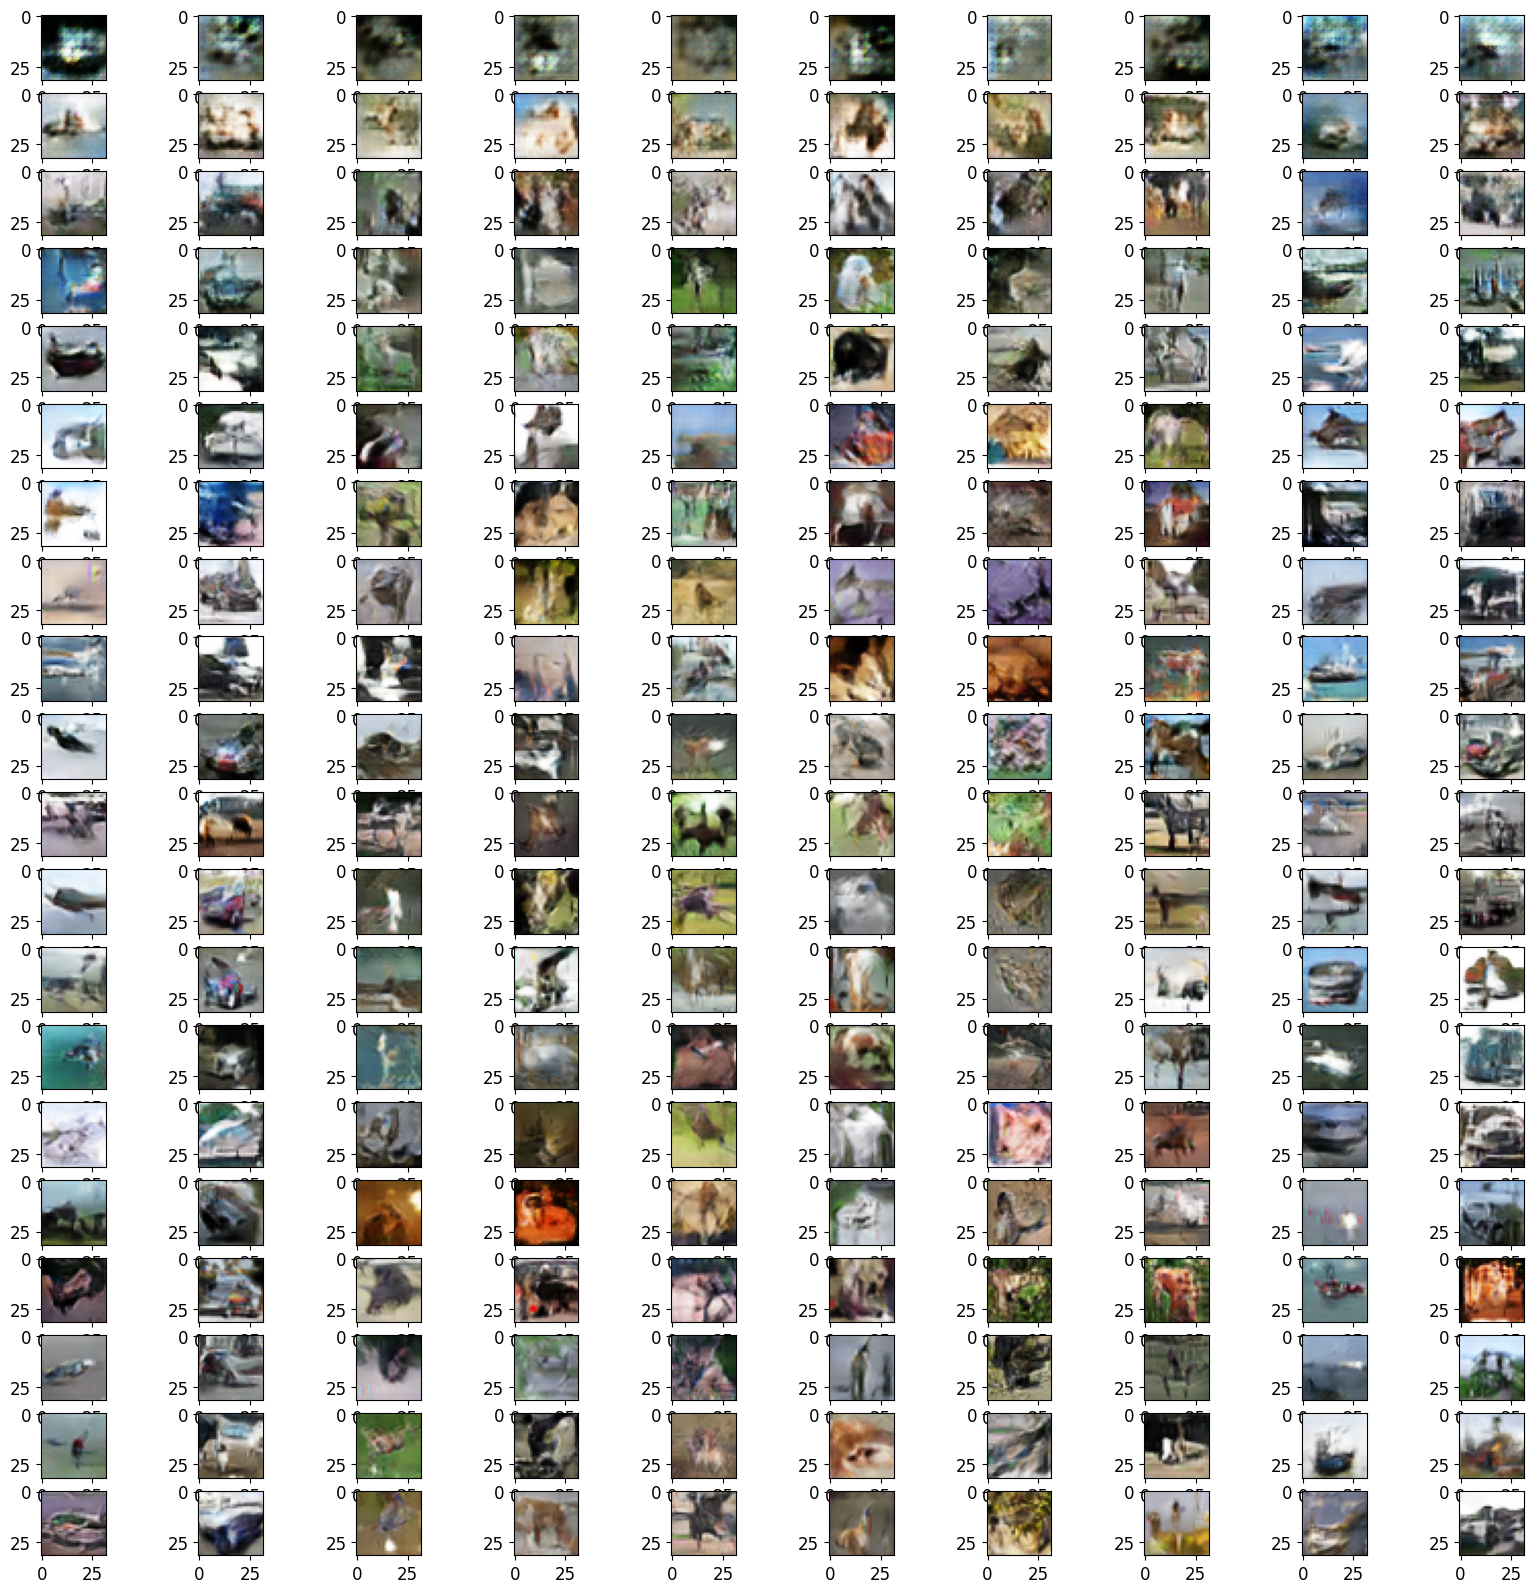

In [19]:
sample_list = []
labels = list(range(10))
for disc_weights, gen_weights in dcgan_200_cond_history._weights[::5]:
    dcgan_200_cond.discriminator.set_weights(disc_weights)
    dcgan_200_cond.generator.set_weights(gen_weights)
    sample_list.append((dcgan_200_cond.sample(labels=labels) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)